# Week 11

Neural Networks

In [2]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

!wget -qO- https://github.com/DM-GY-9103-2024F-H/9103-utils/releases/latest/download/lfw.tar.gz | tar xz

In [3]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset

from data_utils import classification_error, display_confusion_matrix, object_from_json_url
from data_utils import LFWUtils, StandardScaler
from image_utils import open_image, make_image

## More Tensors and Why They're Awesome

Multi-dimensional slicing is definitely a nice property of tensors, but what really sets them apart from fancy lists is their ability to keep track of all the operations performed on them using _computational graphs_.

If we define a tensor and set its `requires_grad` parameter to `True` we unlock some really nice properties that we can use for training neural networks.

One of these properties is the ability to automatically calculate derivatives (OMG, calculus!) of functions defined in terms of our tensor.

Let's investigate.

### Easy Calculus and Free Derivatives

Let's pretend we have the following function:

$f(x) = x^4 - 0.7x^3 - 2x^2 + x + 1$

And we want to find out when the function achieves its minimum values.

We can plot it, and easily approximate those values visually:

In [4]:
def peaks(x):
  return x**4 - 0.7*x**3 - 2*x**2 + x + 1

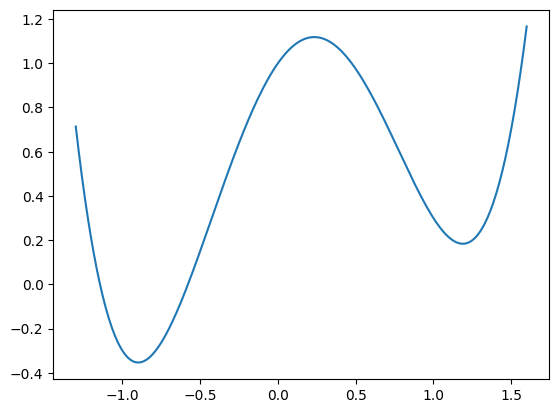

In [5]:
# linspace is range()'s cousin, but for floats 
#   and where the 3rd argument specifies number of steps, not length of steps

x = torch.linspace(-1.3, 1.6, 300)
y = peaks(x)

plt.plot(x, y)
plt.show()

Looks like local minimum values are approximately:
- $x = -0.9$ (global minimum)
- $x = 1.2$ (local minimum)

We can calculate exact values for these points in our graph if we define $x$ and $y$ as tensors and enable their `auto_grad` functionality.

derivatives: tensor([-6.1370, -6.1291, -6.1212, -6.1134, -6.1055])


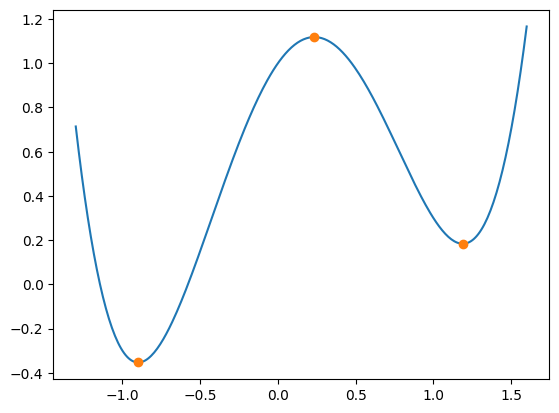

min/max: tensor([-0.8983,  0.2339,  1.1892], grad_fn=<IndexBackward0>) tensor([-0.3536,  1.1185,  0.1835], grad_fn=<IndexBackward0>)


In [ ]:
xt = torch.linspace(-1.3, 1.6, 8000, requires_grad=True)
yt = peaks(xt)
# getting the slope of the line at each point 
yt.backward(torch.ones_like(xt))

dydx = xt.grad
print("derivatives:", dydx[:5])

# trying to find when slope is really small 
# 0 indicates change in direction
minmax_idx = (dydx.abs() < 9e-4)
minmax_y = yt[minmax_idx]
minmax_x = xt[minmax_idx]

plt.plot(x, y)
plt.plot(minmax_x.tolist(), minmax_y.tolist(), 'o')
plt.show()

print("min/max:", minmax_x, minmax_y)

### Wait. What?

Let's look at the individual commands from the cell above.

`xt`: this is a $1D$ tensor of shape $8000$ with value from $-1.3$ to $1.6$.

`yt`: this is a $1D$ tensor of shape $8000$ which holds the results of calling `peaks()` on every value of `xt`.

`yt.backwards(torch.ones_like(xt))`: this calculates the derivatives (slope) of the equation `peak()` for every point of `yt` and `xt`. The `torch.ones_like(xt)` parameter is a bit unconventional and usually we'll just call `backwards()` without any parameters. It's necessary here because instead of asking for the derivative of an equation at one specific point, we want to get the derivatives for all points in our `xt` range tensor.

`dydx = xt.grad`: after calling `backward()` on a tensor (`yt`) that depends on tensors with `requires_grad` (`xt`), the tensors with `requires_grad` will have their gradients/slope store in the `grad` member variable.

`minmax_idx = (dydx.abs() < 9e-4)`: since our function is being evaluated on a discrete set of values inside `xt`, we might not have the exact `xt` that gives an exact slope of $0$, so `dydx.abs() < 9e-4` is a boolean indexing of all values of dydx that are really close to $0$.

`minmax_y = yt[minmax_idx]` and `minmax_x = xt[minmax_idx]`: this gets the actual `x` and `y` values where the slope of `peaks()` is really really close to $0$.

### Solving for min iteratively

Our `peaks()` function is pretty simple, as it only depends on one variable, `x`, and the range we're calculating it over is pretty small, $[-1.2, 1.6]$.

What if our `peaks()` function was more complex and it took minutes to calculate? How can we find its `min` or `max` values?

This is the more common case for `grad` and `backward()`. We evaluate a function once, at one specific input value, and calculate which direction it should move in order to increase or decrease the value of our function.

We can use the `peaks()` function to illustrate. Let's calculate the value of `x` that gives the smallest value for `peaks(x)`.

`xm`: this is the current guess for the value of `x` which gives the smallest value for `peaks()`. We'll initialize it at $0.15$, which is the halfway point of our `x` range.

`xms` and `yms`: these will hold the progression of the `xm` and `ym` variables as they move towards their objectives.

`ym`: the value of `peaks()` at the current `xm`.

`backwards()`: calculate the slope of `ym` with respect to its inputs.

`xm = xm + 0.1 * xm.grad`: update `xm` according to the slope of `peaks()` at `xm`. If the slope is positive, decrease `xm`, if the slope is negative, increase `xm`. This will move `x_m` towards a minimum value of `peaks()`. If we wanted to move towards a maximum value, we increase `xm` for positive slopes and decrease it for negative slopes.

The $0.1$ factor determines how big our steps should be when we update `xm`. There's a tradeoff here: large steps can get to the desired value quicker, but can also totally skip the desired value and end up in some non-desired part of our equation. Small steps, on the other hand, take a little longer to find the objective, but usually converge on the correct value.

`xm.retain_grad()`: again, we're using tensors for educational purposes here, and accumulating gradients in an unconventional way. We have to call this to make sure we can later access the gradient of something that was itself calculated from a gradient. This won't be like this in actual modeling code.

A tensor's `item()` member function just returns that tensor's value as a regular `Python` number. Similarly, if we want to get a tensor as a regular `Python` list we can call its `tolist()` function.

In [ ]:
xs = []
ys = []

xm = torch.tensor(0.15, requires_grad=True)

ym = peaks(xm)
ym.backward()
print(xm.item(), ym.item(), xm.grad.item())

xs.append(xm.item())
ys.append(ym.item())

xm = xm - 0.1 * xm.grad
xm.retain_grad()

ym = peaks(xm)
ym.backward()
print(xm.item(), ym.item(), xm.grad.item())

xs.append(xm.item())
ys.append(ym.item())

# TODO: more steps

### X's journey

We saved all of the intermediate values of `xm` and `ym` so we can plot them here:

In [ ]:
plt.plot(x, y)
plt.scatter(xs, ys, marker='o', s=14, c='r')
plt.show()
xs[-1], ys[-1]

### Taking all the steps

We took one step. We could loop and take $10$ steps, or take as many steps as are necessary to get to the closest max/min value of our function.

Let's add a loop to the cell above that repeats the following:

- calculate `ym`
- save `xm` and `ym`
- calculate `gradient`
- update `xm`
- repeat

## Ok, so what ?

Neural Networks is what, because now we have the most important ingredient for training a neural network to perform regression (or classification, or whatever else).

We know how to load data into a `DataFrame`, once we pass this data through a neural network with random values for its parameters, we can calculate the `error` of our cost function in relation to all of the parameters of the network, and then calculate which direction to move all of the parameters to decrease our error.

Let's load the housing prices dataset from `HW03`.

As always, we'll encode and scale our data if needed, and then we'll use the `train_test_split()` function to split our `DataFrame` into $2$ separate datasets, a training dataset with $80\%$ of the rows, and a test dataset with $20\%$.

In [ ]:
# Define the location of the json file here
HOUSES_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/LA_housing.json"

houses_info = object_from_json_url(HOUSES_FILE)

houses_raw_df = pd.DataFrame.from_records(houses_info)

house_scaler = StandardScaler()
houses_df = house_scaler.fit_transform(houses_raw_df)

houses_train, houses_test = train_test_split(houses_df, test_size=0.2)

houses_train.head()

### Create features

Just like with the `LinearRegression` models, we have to separate our independent features and our outcome feature.

This time we put them both into tensors.

The `x` tensor holds all of the independent features for all of the data points, and the `y` tensor their corresponding outcomes (prices).

In [ ]:
train_features = houses_train.drop(columns=["value"])
train_values = houses_train["value"]

x_train = Tensor(train_features.values)
y_train = Tensor(train_values.values)

### Define our model

We'll use a very basic neural network model that has an input layer with a neuron for each feature, and a single output neuron for the price prediction.

Something like this:

<img src="./imgs/linear_5x1.jpg" width="800px"/>

Where the initial values for the model parameters are selected at random by default.

We can iterate over out model's parameters and print their shapes, or calculate overall number of parameters using the `numel()` function of each parameter.

In [ ]:
model = nn.Linear(len(train_features.columns), 1)

psum = 0

for p in model.parameters():
  print(p.shape)
  psum += p.numel()

print("number of parameters:", psum)

### Test model

We can run this model on our train dataset just to make sure all of our layers have the correct shapes.

If anything is off we'll get an error here.

We're giving our model a `Tensor` with $4623$ houses and $5$ features for each house. It should give us $4623$ predictions.

In [ ]:
print(x_train.shape)
y = model(x_train)
print(y.shape, y[0])

### Set up training

This will look similar to the iterative approach for finding the minimum value of a function we saw above.

For each step of our iteration we will:

- calculate a price prediction for all of the rows in our dataset
- calculate the overall error for all of the price predictions
- calculate the derivative of this error with respect to the model parameters
- update model parameters to decrease error
- repeat

A few things to note about this process:

1\. We are calculating all of the predictions for all of our data with a single call: `y = model(x)`. `PyTorch` models are smart and they know we want to do the same thing for all of the rows in our data. This optimizes and parallelizes the process.

2\. But... if we take a look at the resulting shape of the call to `model(x)` we'll see that it adds an extra dimension to our predictions, which we must remove by calling `reshape(-1)`.

3\. The cost function (called `loss` here) is the `L2` distance between all price predictions and all actual prices in our dataset calculated in one go. It's a single number we can take the derivative of. We could skip the square root, but this way our units stay consistent and error is calculated in terms of standard deviations.

4\. The parameters we are optimizing and updating at each iteration aren't our features, but the weights and thresholds of each of our $6$ neurons, which have `requires_grad` turned on by default. At each step we update the model's parameters with `p.data.sub_(p.grad.data * learning_rate)`. This is the very bureaucratic form of doing something like: `p -= p * lr`. Since we are dealing with parameter tensors that keep all kinds of extra information about their values, we have to operate on their `data` members.

5\. Once we have used the parameters' gradients to update our model we have to clear them by calling `grad.zero_()`. We'll see why soon, but by default if we are reusing the same tensors (in this case our model's parameters) we have to make sure they don't accumulate gradients.

In [ ]:
learning_rate = 1e-2

for c in range(32):
  y_pred = model(x_train).reshape(-1)
  loss = (y_pred - y_train).pow(2).mean().pow(0.5)
  loss.backward()

  for p in model.parameters():
    p.data.sub_(p.grad.data * learning_rate)
    p.grad.zero_()

  if c % 4 == 0:
    print(c, loss.item())

### Interpretation

What's happening in the above cell?

What happens if we keep running it over and over?

### Checking the train dataset

Once we're happy with the training, we can get predictions for all of our houses in dollars by running the model and reversing the scaling:

In [ ]:
y_std = pd.DataFrame(model(x_train).tolist(), columns=["value"])
y_usd = house_scaler.inverse_transform(y_std)

y_usd.head()

### Growing the Network

The error we were getting above was around $1.0$ standard deviation. That's not bad, but it's also not good.

If we want to improve our model we can try adding layers to our Neural Network. We just have to make sure we add an activation function between the neurons. These are the functions that keep our model parameters within a nice, well-defined, range.

This is how we build the following network:

<img src="./imgs/linear_5x5x1.jpg" width="800px"/>

In [ ]:
model =  nn.Sequential(
  nn.Linear(len(train_features.columns), len(train_features.columns)),
  nn.Sigmoid(),
  nn.Linear(len(train_features.columns), 1),
)

# TODO: calculate the number of parameters
# TODO: test on train data and check shape of output

### So... many... parameters

How many parameters do we have now? We might not want to keep updating them ourselves.

Relying on a for loop to get all the parameters and remembering to call `grad.zero_()` at the right time is just prone to errors and inefficiencies.

Luckily, `PyTorch` has some optimizers we can use. They usually take our model as an input, along with some other parameters, and give us a simpler interface to control the optimization process.

### Initialize Optimizer

We're going to use one of the simpler optimizers to performs [_stochastic gradient descent_](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). Gradient descent is the official name of the algorithm that calculates which way to update our parameters given the slope of our cost function and a learning rate. _Stochastic_ means that it should still work if we sub-sample our input data and only use a subset of the data points at a time. It remembers/accumulates information about previous error measurements.

The documentation for the [`SGD` optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) has more info about the algorithm and the parameters it takes.

Other than simplifying our training code, these pre-built optimizers also perform dynamic learning rate adjustment and some other tricks that make our overall process not so sensitive to an exact learning rate.

The `PyTorch` library also has a number of [other optimizers](https://pytorch.org/docs/stable/optim.html#algorithms) useful for performing gradient descent. In addition to `SGD()` we can also try [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) or [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html).

In [ ]:
learning_rate = 1e-2
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train it

We can train our new model, just like before, except now the training loop should be a little bit simpler.

We still have to call `zero_grad()`, but only on the optimizer. It will take care of clearing the gradients for each of the model's parameters for us.

And, after we calculate the slope of our cost function, we call `optim.step()`, so the optimizer can update the parameters with a new slope value.

In [ ]:
for c in range(32):
  optim.zero_grad()
  y_pred = model(x_train).reshape(-1)
  loss = (y_pred - y_train).pow(2).mean().pow(0.5)
  loss.backward()
  optim.step()

  if c % 4 == 0:
    print(c, loss.item())

### Test dataset

We can still adjust a lot of parameters here, but before we spend too much time on this model, let's run it on the test dataset and calculate the average loss on data that wasn't used for training to see if the model is over-fitting.

We'll load the test data, run the mode and calculate loss.

In [ ]:
test_features = houses_test.drop(columns=["value"])
test_values = houses_test["value"]

x_test = torch.Tensor(test_features.values)
y_test = torch.Tensor(test_values.values)

### `no_grad()`

We can call the `torch.no_grad()` function to tell `PyTorch` to momentarily stop calculating slopes/gradients when we are not training and just want to use the model to predict prices. We do this by creating a block of code where our model runs faster and more carefree.

In [ ]:
with torch.no_grad():
  y_pred = model(x_test).reshape(-1)
  loss = (y_pred - y_test).pow(2).mean().pow(0.5)
  print(loss.item())

### Interpretation

This isn't bad.

The absolute value of the error is kind of large, but the test dataset error is comparable to the training dataset error, which is a good indication that the model is not over-fitting.

And it seems to be learning, so let's tune it.

### Hyperparameters

We can spend some time adjusting the model, adding layers, changing the optimizer, the learning rate, experimenting with the optimizer's parameters, etc.

This process is usually referred to as hyperparameter tuning, since we're picking parameters that will help us calculate the parameters of our neural network.

Here's a cell with all of the steps combined. We can play with the network architecture and parameters here.

In [ ]:
## Define Model
model =  nn.Sequential(
  nn.Linear(len(train_features.columns), len(train_features.columns)),
  nn.Sigmoid(),

  # TODO: add layers

  nn.Linear(len(train_features.columns), 1),
)

# TODO: calculate the number of parameters

## Define Optimizer
learning_rate = 1e-2
# TODO: adjust parameters, add parameters, change optimizer
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Load Data
x_train = torch.Tensor(train_features.values)
y_train = torch.Tensor(train_values.values)
x_test = torch.Tensor(test_features.values)
y_test = torch.Tensor(test_values.values)

## Train Model
for c in range(32):
  optim.zero_grad()
  y_pred = model(x_train).reshape(-1)
  loss = (y_pred - y_train).pow(2).mean().pow(0.5)
  loss.backward()
  optim.step()

  if c % 4 == 0:
    print(c, loss.item())

## Evaluate Model
with torch.no_grad():
  y_pred = model(x_train).reshape(-1)
  loss_train = (y_pred - y_train).pow(2).mean().pow(0.5)

  y_pred = model(x_test).reshape(-1)
  loss_test = (y_pred - y_test).pow(2).mean().pow(0.5)

  print("\ntrain loss:", loss_train.item(), "\ntest loss:", loss_test.item())

### Interpretation

Our model is definitely learning. It might take a moment to tune and train before we get something comparable to the `LinearRegression` model, but that's not entirely surprising.

Usually what makes the biggest difference in these kinds of models is the size of the training dataset, compared to the number of parameters the model has to learn.

Some of the same tricks we used for the `LinearRegression` model could also help here. In theory the neural network should learn how to combine parameters into polynomial features, and also how to combine features akin to `PCA`, but sometimes it needs a little push in the right direction.

## Images

Can we use these kinds of models to do classification of images?

Sure.

The steps are the same, we just have to load image data and adapt the cost/loss function to calculate some kind of classification metric instead.

We'll use the _Labeled Faces in the Wild_ dataset from last homework.

The steps for setting up the classification model will be:

- Load dataset and do any kind of pre-processing
- Split data into train/test datasets
- Split independent features and classification label and load them into `Tensors`
- Create `DataLoader` instances (we'll see what this means below)
- Build a NN model
- Set up an optimizer
- Pick a cost/loss function
- Implement an evaluation function and any other kind of visualization that helps quantify the model
- Train model

### Load and split Dataset

The `LFWUtils.train_test_split(0.333)` function gives us some `Python` objects we can use to create our `Tensor`s.

The `pixels` key gives us a list of the images' pixel data, and the `label` key gives us the images' label IDs.

We don't have to do any normalization since the pixels will be in a know, well-defined range of $[0 - 255]$.

The only thing we have to do differently is cast the label `Tensor` to `long`. This is just to ensure the numbers in those `Tensor`s are whole numbers and don't have decimal points.

In [ ]:
train, test = LFWUtils.train_test_split(0.5)

x_train = torch.Tensor(train["pixels"])
y_train = torch.Tensor(train["labels"]).long()

x_test = torch.Tensor(test["pixels"])
y_test = torch.Tensor(test["labels"]).long()

len(x_train), len(x_test)

### Look at data

We can visualize some of the images, their text labels and label IDs

In [ ]:
for idx in range(0, len(train["pixels"]), 180):
  display(make_image(train["pixels"][idx], 130))
  print(train["labels"][idx], LFWUtils.LABELS[train["labels"][idx]])

### Datasets & DataLoaders

This is new !

We could try to train this neural network exactly how we trained the previous one where we gave the model the entire training dataset at once and asked for it to minimize the cost function over all of the samples at the same time.

This could work for this dataset, but once we start working with bigger and bigger datasets, it will be difficult to ask the computer to perform this kind of optimization over all of the images at the same time.

We have to split up our dataset into batches, and ask the model to work on subsets of our datasets. Since we're not giving the model all of the data at once, we should also randomize the order of the data to make sure the order in which the model sees a sample doesn't affect its influence on the overall quality of the model.

We'll use `PyTorch`'s built in [Datasets and DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) classes to help us manage our batches of training data.

### Define a Dataset Class

The first thing we have to do is define a `PyTorch` `Dataset` class that will handle our pixel and label data.

This class need to have $3$ functions defined:

`__init__()`: the constructor. Should receive all the info from a dataset.

`__len__()`: this returns how many items we have in out dataset.

`__getitem__()`: given an index, return the corresponding pixels and label.

In [ ]:
class FaceDataset(Dataset):
  def __init__(self, imgs, labels):
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.imgs = imgs.to(self.device)
    self.labels = labels.to(self.device)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.imgs[idx], self.labels[idx]

### Create DataLoaders

Now we can just create `Dataset` instances for each of our $2$ datasets, and pass those along to the `DataLoader` constructor.

In the `DataLoader` constructor we can use the `batch_size` parameter to define how many images the model should consider each time it does gradient descent, and the `shuffle` parameter to specify whether the data should be randomized during that process.

Setting parameters for the training `DataLoader` is more important since the batch size and randomization will directly affect the quality of the model.

For the test `DataLoader` the batch size won't really make a difference in the results, although larger batches should evaluate faster, and shuffling might confuse us when we try to look at specific test cases that are failing.

In [ ]:
train_dataloader = DataLoader(FaceDataset(x_train, y_train), batch_size=128, shuffle=True)
test_dataloader = DataLoader(FaceDataset(x_test, y_test), batch_size=512)

### Model, Optimizer and Cost Function

We'll start with the simplest kind of network again, with just an input and an output layer.

The input layer has as many neurons as the number of pixels in each image, and the output layer has one neuron per possible class.

It looks like this, and is juts like our regression network above, but has more output neurons:

<img src="./imgs/linear_22100x26.jpg" width="800px"/>

Our optimizer will be `SGD` again. Depending on the dataset and model being created, `SGD` can perform even better with batched inputs because it is looking at less data and is less constrained within each batch.

Our cost function is a bit different. Previously, we used $L2$ distances to calculate the root mean square error of our regression predictions and used that value as the cost function for gradient descent.

In order to use gradient descent for classification, we have to turn the discrete nature of our labels/classes and their errors into something that has smooth and integratable slopes.

That's what the `CrossEntropyLoss()` function does for us. It looks at the outputs of our model and transforms the regression-type continuous values at our outputs into class prediction probabilities in a way that gradient descent still works.

There's more information in the [`PyTorch` documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [ ]:
mdevice = "cuda" if torch.cuda.is_available() else "cpu"
model = nn.Linear(x_train.shape[1], len(y_train.unique())).to(mdevice)

learning_rate = 1e-5
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

### Test Shapes

In [ ]:
img, label = next(iter(train_dataloader))
img.shape, model(img).shape

### Train the Model

We can train the model now.

We still don't have an evaluation function, but we can use the values from the loss function to adjust parameters and make sure that the model is learning.

We'll train for $32$ epochs, and in each epoch we have to iterate through the data that is inside our `DataLoader` object.

The `x` and `y` variables below actually hold pixel and label information for $256$ images. For each of these batches we predict labels, calculate loss, calculate the slope of the loss function, update model parameters, zero the gradients, and repeat.

In [ ]:
for e in range(32):
  for x, y in train_dataloader:
    optim.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optim.step()

  if e % 2 == 0:
    print(f"Epoch: {e} loss: {loss.item():.4f}")

### Interpretation

The loss/cost value seems to oscillate up and down, but, overall should steadily decrease.

This up and down has to do with the batching and shuffling of our training data. The `SGD` optimizer makes some decisions that it sometimes has to undo, but overall, the model looks like it's learning.

We can keep running this cell until the loss gets really small, but what we should do next is think of a way to evaluate our model using the test dataset and a function that gives us something a little more legible than the `CrossEntropyLoss()` value which is the sum of the "negative log likelihood" of our predictions.

This evaluation function is helpful not only when measuring the overall quality of our model, but should help us detect if/when the model starts to overfit the training data.

### Evaluation Function

Our `data_utils` file has a `classification_error()` function that calculates a percentage of mistakes between two lists of labels. We just have to give it a list of true labels and a list of predicted labels.

Having these lists of labels will also be useful if we want to visualize our predictions in a confusion matrix, so let's write a helper function that takes a model and a `DataLoader` and computes predictions for all of the samples in that dataloader.

We'll make sure our model isn't computing gradients with `torch.no_grad()` and also turn off some other features of the model that don't have to run during evaluation with `model.eval()`.

The `argmax(dim=1)` function gives us the index of our output neuron with the largest value. This is how we pick a class label from the raw regression-like numbers.

Then we append a list of labels to our overall list of prediction and true labels.

In [ ]:
def get_labels(model, dataloader):
  model.eval()
  with torch.no_grad():
    data_labels = []
    pred_labels = []
    for x, y in dataloader:
      y_pred = model(x).argmax(dim=1)
      data_labels += [l.item() for l in y]
      pred_labels += [l.item() for l in y_pred]
    return data_labels, pred_labels

### Evaluate Model

We can now run the evaluation function on the model and both `DataLoaders`.

In [ ]:
train_labels, train_predictions = get_labels(model, train_dataloader)
test_labels, test_predictions = get_labels(model, test_dataloader)

print("train error:", f"{classification_error(train_labels, train_predictions):.4f}")
print("test error", f"{classification_error(test_labels, test_predictions):.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)

### Re-Train with Evaluation

To make sure our model didn't overfit the training data, we should keep an eye on the evaluation function during training.

Let's re-initialize our model and optimizer and re-train our network:

In [ ]:
mdevice = "cuda" if torch.cuda.is_available() else "cpu"
model = nn.Linear(x_train.shape[1], len(y_train.unique())).to(mdevice)

learning_rate = 1e-5
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
for e in range(32):
  for x, y in train_dataloader:
    optim.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optim.step()

  if e % 4 == 0:
    train_labels, train_predictions = get_labels(model, train_dataloader)
    test_labels, test_predictions = get_labels(model, test_dataloader)
    train_error = classification_error(train_labels, train_predictions)
    test_error = classification_error(test_labels, test_predictions)
    print(f"Epoch: {e} loss: {loss.item():.4f}, train error: {train_error:.4f}, test error: {test_error:.4f}")

In [ ]:
train_labels, train_predictions = get_labels(model, train_dataloader)
test_labels, test_predictions = get_labels(model, test_dataloader)

print("train error:", f"{classification_error(train_labels, train_predictions):.4f}")
print("test error", f"{classification_error(test_labels, test_predictions):.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)

### Interpretation

Is it overfitting ? Can we keep running the training cell ?

How low can we get our test error ?

### Add Layers

Maybe we can improve our classification by adding some hidden layers.

In [ ]:
mdevice = "cuda" if torch.cuda.is_available() else "cpu"
model =  nn.Sequential(
  nn.Linear(x_train.shape[1], x_train.shape[1] // 2),
  nn.ReLU(),

  nn.Linear(x_train.shape[1] // 2, x_train.shape[1] // 16),
  nn.ReLU(),

  nn.Linear(x_train.shape[1] // 16, x_train.shape[1] // 32),
  nn.ReLU(),

  nn.Dropout(0.4),
  nn.Linear(x_train.shape[1] // 32, len(y_train.unique())),
).to(mdevice)

learning_rate = 1e-5
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

img, label = next(iter(train_dataloader))
model(img).shape

In [ ]:
for e in range(32):
  for x, y in train_dataloader:
    optim.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optim.step()

  if e % 4 == 0:
    train_labels, train_predictions = get_labels(model, train_dataloader)
    test_labels, test_predictions = get_labels(model, test_dataloader)
    train_error = classification_error(train_labels, train_predictions)
    test_error = classification_error(test_labels, test_predictions)
    print(f"Epoch: {e} loss: {loss.item():.4f}, train error: {train_error:.4f}, test error: {test_error:.4f}")

In [ ]:
train_labels, train_predictions = get_labels(model, train_dataloader)
test_labels, test_predictions = get_labels(model, test_dataloader)

print("train error:", f"{classification_error(train_labels, train_predictions):.4f}")
print("test error", f"{classification_error(test_labels, test_predictions):.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)

### Interpretation

The result is mostly the same, which is not surprising.

We did add layers, but the network didn't need any extra neurons to do well on the training data.

It needs help with the testing data, or, another way to say this is: it needs help generalizing without memorizing.

### Make It Harder

Neural network models can seem simple to explain in a general sense: they're long and wide computation graphs made up of simple operations that have been tuned to achieve a specific task. Once they're training, or trained, their details and specificities are a little less easy to describe. It's hard to know exactly what each neuron is doing, and what part of the computation they are responsible for. We can train the same network, with the same parameters, using the same input data, and end up with wildly different results.

This is one reason why it's hard to debug a network when it doesn't seem to be learning properly, or when it starts to overfit and memorize the training data. Which neurons do we tune ?

One common situation that can lead to overfitting is when a network ends up with parameters that make it perform well on the training data without really activating all of its neurons. This is usually what is happening if adding layers to a network doesn't improve its performance.

One set of strategies for improving neural network training in these cases involves making the training process harder than it has to be. It's like we're challenging the neural network to learn more than it has, so that later it has an easier time with the regular data.

#### Dropout

One simple technique to achieve this is to add `Dropout` layers to our network. A `Dropout` layer is a layer of neurons that don't perform any mathematical operation, but are selectively dropped out of the network randomly during training. This has the effect of randomly changing the network's architecture during training and preventing the network from becoming too reliant on specific neurons. Instead, it encourages the network to learn more robust features by activating more diverse sets of neurons.

<img src="./imgs/dropout.jpg" width="800px"/>

#### Activation Normalization

Another technique that is used to keep our neural networks from memorizing data has to do with the range of the values that get passed between its inner layers.

Input data coming into the network is most likely normalized, but after the first layer, the network weights might really change the distribution of the data as it flows through the network. Moreover, individual batches with different input value distributions can bias the network towards certain goals.

<img src="./imgs/norm_activation.jpg" width="720px"/>

#### Batch Normalization

One way to handle these situations is to normalize the data as it passes through the network. Batch Normalization is the process of normalizing the activations of our network by using the mean and standard deviation of an activation neuron across a batch. The result is that the activations between batches become more similar. Batch normalization is dependent on batch size, so it's not effective for small batches.

<img src="./imgs/norm_batch.jpg" width="720px"/>

#### Layer Normalization

Another form of inner-network normalization can be added to make sure no individual layer overpowers the network with activation values that are too large or too small.

Layer Normalization scales activations using the mean and standard deviation of all activations across a layer. It's effective for sequence models like RNNs and Transformers, and for scenarios with small batch sizes, and doesn't require a large batch to get a good estimate for mean and standard deviation. 

<img src="./imgs/norm_layer.jpg" width="720px"/>

In [ ]:
model =  nn.Sequential(
  nn.Dropout(0.35),
  nn.Linear(x_train.shape[1], x_train.shape[1] // 2),
  nn.BatchNorm1d( x_train.shape[1] // 2),
  nn.ReLU(),
  # nn.LayerNorm(x_train.shape[1] // 2),

  nn.Dropout(0.35),
  nn.Linear(x_train.shape[1] // 2, x_train.shape[1] // 16),
  nn.BatchNorm1d(x_train.shape[1] // 16),
  nn.ReLU(),
  # nn.LayerNorm(x_train.shape[1] // 16),

  nn.Dropout(0.35),
  nn.Linear(x_train.shape[1] // 16, x_train.shape[1] // 32),
  nn.BatchNorm1d(x_train.shape[1] // 32),
  nn.ReLU(),
  # nn.LayerNorm(x_train.shape[1] // 32),

  nn.Dropout(0.35),
  nn.Linear(x_train.shape[1] // 32, len(y_train.unique())),
).to(mdevice)

# lr := [1e-4, 1e-2]
learning_rate = 5e-3
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

img, label = next(iter(train_dataloader))
model(img).shape

In [ ]:
for e in range(32):
  model.train()
  for x, y in train_dataloader:
    optim.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optim.step()

  if e % 4 == 0:
    train_labels, train_predictions = get_labels(model, train_dataloader)
    test_labels, test_predictions = get_labels(model, test_dataloader)
    train_error = classification_error(train_labels, train_predictions)
    test_error = classification_error(test_labels, test_predictions)
    print(f"Epoch: {e} loss: {loss.item():.4f}, train error: {train_error:.4f}, test error: {test_error:.4f}")

### Interpretation

The train and test eval function diverged, but both keep decreasing, so this might be ok.

In [ ]:
train_labels, train_predictions = get_labels(model, train_dataloader)
test_labels, test_predictions = get_labels(model, test_dataloader)

print("train error", f"{classification_error(train_labels, train_predictions):.4f}")
print("test error", f"{classification_error(test_labels, test_predictions):.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)